In [133]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
#from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import StandardScaler
r = pd.read_pickle("sample.pickle")

def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values("date").index.unique()
    train_id_list = sorted_id_list[: round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)) :]
    train = df.loc[train_id_list]#.drop(['date'], axis=1)
    test = df.loc[test_id_list]#.drop(['date'], axis=1)
    return train, test

In [140]:
#r = r.fillna(0).astype(int)

train, valid = split_data(r)
train, test = split_data(train)

In [139]:
print("train .{}".format(train.shape),\
     "test .{}".format(test.shape),\
     "valid .{}".format(valid.shape))

train .(23419, 180) test .(13991, 180) valid .(9708, 180)


In [279]:
#NNようのデータ制作　引数に前処理されたデータを入力することでNN用のデータ分割、処理を行う
class NN_data():
    def __init__(self, data, rank=False):
        train, test = split_data(data)
        train, valid = split_data(train)

        if rank == True:
            X_train = train.drop(["rank","ranking","単勝","second","着順","rls","data","date"], axis=1)
            X_train = X_train.fillna(0).astype(int)
            y_train = train["rank"]

            X_test = test.drop(["rank","ranking","単勝","second","着順","rls","data","date"], axis=1)
            X_test = X_test.fillna(0).astype(int)
            y_test = test["rank"]

            X_valid = valid.drop(["rank","ranking","単勝","second","着順","rls","data","date"], axis=1)
            X_valid = X_valid.fillna(0).astype(int)
            y_valid = valid["rank"]

            self.X_train = X_train
            self.y_train = y_train
            self.X_test = X_test
            self.y_test = y_test
            self.X_valid = X_valid
            self.y_valid = y_valid
            
            #return self.X_train,self.y_train, self.X_test,self.y_test, self.X_valid,self.y_valid
        
        else:
            X_train = train.drop(["rank","ranking","単勝","second","着順","rls","data","date"], axis=1)
            X_train = X_train.fillna(0).astype(int)
            y_train = train["ranking"]

            X_test = test.drop(["rank","ranking","単勝","second","着順","rls","data","date"], axis=1)
            X_test = X_test.fillna(0).astype(int)
            y_test = test["ranking"]

            X_valid = valid.drop(["rank","ranking","単勝","second","着順","rls","data","date"], axis=1)
            X_valid = X_valid.fillna(0).astype(int)
            y_valid = valid["ranking"]
            
            self.X_train = X_train
            self.y_train = y_train
            self.X_test = X_test
            self.y_test = y_test
            self.X_valid = X_valid
            self.y_valid = y_valid
            
            #return self.X_train,self.y_train, self.X_test,self.y_test, self.X_valid,self.y_valid

        X_train = np.array(X_train) 
        y_train = np.array(y_train) 
        X_test = np.array(X_test) 
        y_test = np.array(y_test) 
        X_valid = np.array(X_valid) 
        y_valid = np.array(y_valid) 

        X_train =X_train.astype(np.float32)
        y_train = y_train.astype(np.int32)[:] 
        X_test =X_test.astype(np.float32)
        y_test = y_test.astype(np.int32)[:] 
        X_valid =X_valid.astype(np.float32)
        y_valid = y_valid.astype(np.int32)[:] 

        sc = StandardScaler()

        X_train = sc.fit_transform(X_train)
        X_test = sc.fit_transform(X_test)
        X_valid = sc.fit_transform(X_valid)

        self.X_train = X_train
        self.X_test = X_test
        self.X_valid = X_valid
        
        self.y_train = y_train
        self.y_test = y_test
        self.y_valid = y_valid


In [242]:
model = keras.models.Sequential()

#全結合層　接続ノード数344, 活性化関数relu, インプット数172
model.add(keras.layers.Dense(400, activation="relu", input_shape=NN_data(r).X_train.shape[1:])) #1 or 0

#2
model.add(keras.layers.Dense(120, activation="relu"))

#3
model.add(keras.layers.Dense(240, activation="relu"))

#4
model.add(keras.layers.Dense(480, activation="relu"))

#5
model.add(keras.layers.Dense(240, activation="relu"))

#6
model.add(keras.layers.Dense(120, activation="relu"))

#7
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 400)               69200     
_________________________________________________________________
dense_38 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_39 (Dense)             (None, 240)               29040     
_________________________________________________________________
dense_40 (Dense)             (None, 480)               115680    
_________________________________________________________________
dense_41 (Dense)             (None, 240)               115440    
_________________________________________________________________
dense_42 (Dense)             (None, 120)               28920     
_________________________________________________________________
dense_43 (Dense)             (None, 1)                

In [243]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.\
              Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0, amsgrad=False),\
             metrics=["accuracy"])

In [245]:
history = model.fit(NN_data(r).X_test, NN_data(r).y_test, epochs=128,\
                    batch_size = 1024,\
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/128
14/14 [==============================] - 1s 44ms/step - loss: 0.4074 - accuracy: 0.0764 - val_loss: 1.6161 - val_accuracy: 0.2240
Epoch 2/128
14/14 [==============================] - 1s 37ms/step - loss: -0.2419 - accuracy: 0.0745 - val_loss: 3.8771 - val_accuracy: 0.2240
Epoch 3/128
14/14 [==============================] - 1s 37ms/step - loss: -1.1960 - accuracy: 0.0751 - val_loss: 9.5106 - val_accuracy: 0.2240
Epoch 4/128
14/14 [==============================] - 1s 37ms/step - loss: -3.4308 - accuracy: 0.0735 - val_loss: 23.2735 - val_accuracy: 0.2240
Epoch 5/128
14/14 [==============================] - 1s 37ms/step - loss: -11.3197 - accuracy: 0.0751 - val_loss: 59.9610 - val_accuracy: 0.2240
Epoch 6/128
14/14 [==============================] - 1s 37ms/step - loss: -32.6529 - accuracy: 0.0724 - val_loss: 153.1414 - val_accuracy: 0.2240
Epoch 7/128
14/14 [==============================] - 1s 37ms/step - loss: -88.4528 - accuracy: 0.0735 - val_loss: 379.4829 - val_accuracy

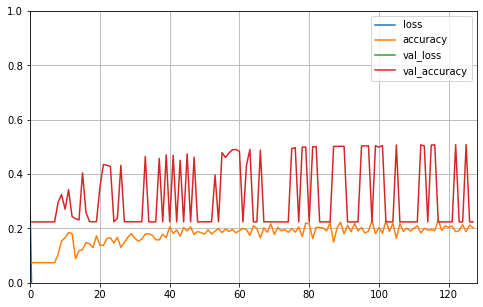

In [246]:
#学習曲線のプロット
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0,1)
plt.gca().set_xlim(0,128)
plt.show()

In [203]:
model.evaluate(NN_data(r).X_valid, NN_data(r).X_valid, verbose=1)

438/438 [==============================] - 1s 1ms/step - loss: 0.6585 - accuracy: 0.7380


[0.6584646701812744, 0.738045871257782]

In [207]:
y_pred = np.argmax(model.predict(NN_data(r).X_train), axis=1)

#print(y_pred.shape)
print("正解データ")
print(y_test)
print("予測結果データ")
print(y_pred)
#print(model.predict(X_test))

正解データ
[1 0 0 ... 0 0 0]
予測結果データ
[0 0 0 ... 0 0 0]


In [239]:
pd.DataFrame(y_test).value_counts()

0    7533
1    2175
dtype: int64

In [238]:
pd.DataFrame(y_pred).value_counts()

0    13991
dtype: int64

In [5]:
#dataset
X = r#.drop(["rank","ranking","単勝","second","着順","rls"],axis=1)
y = r["ranking"]

train1, test = split_data(X)
train2, valid = split_data(train1)

X_train1 = train1.drop(["rank","ranking","単勝","second","着順","rls","data","date"],axis=1)
y_train1 = train1["ranking"]

X_test = test.drop(["rank","ranking","単勝","second","着順","rls","data","date"],axis=1)
y_test = test["ranking"]

X_train2 = train2.drop(["rank","ranking","単勝","second","着順","rls","date","data"],axis=1)
y_train2 = train2["rank"]

X_valid = valid.drop(["rank","ranking","単勝","second","着順","rls","date","data"],axis=1)
y_valid = valid["rank"]

In [98]:
a = X_train2.fillna(0).astype(int)
b = X_valid.fillna(0).astype(int)

In [76]:
for i in range(len(a.columns)):
    print(a.columns[i], (a.isnull().any()[i] == True))

枠番 False
馬番 False
斤量 False
course_len False
horse_id False
jockey_id False
年齢 False
体重 False
体重変化 False
n_horses False
着順_5R False
賞金_5R False
着差_5R False
first_corner_5R False
first_to_rank_5R False
first_to_final_5R False
final_to_rank_5R False
着順_course_len_5R False
賞金_course_len_5R False
着差_course_len_5R False
first_corner_course_len_5R False
first_to_rank_course_len_5R False
first_to_final_course_len_5R False
final_to_rank_course_len_5R False
着順_race_type_5R False
賞金_race_type_5R False
着差_race_type_5R False
first_corner_race_type_5R False
first_to_rank_race_type_5R False
first_to_final_race_type_5R False
final_to_rank_race_type_5R False
着順_開催_5R False
賞金_開催_5R False
着差_開催_5R False
first_corner_開催_5R False
first_to_rank_開催_5R False
first_to_final_開催_5R False
final_to_rank_開催_5R False
着順_9R False
賞金_9R False
着差_9R False
first_corner_9R False
first_to_rank_9R False
first_to_final_9R False
final_to_rank_9R False
着順_course_len_9R False
賞金_course_len_9R False
着差_course_len_9R False
firs

In [104]:
for i in range(len(b.columns)):
    print(b.columns[i], (b.isnull().any()[i] == True))

枠番 False
馬番 False
斤量 False
course_len False
horse_id False
jockey_id False
年齢 False
体重 False
体重変化 False
n_horses False
着順_5R False
賞金_5R False
着差_5R False
first_corner_5R False
first_to_rank_5R False
first_to_final_5R False
final_to_rank_5R False
着順_course_len_5R False
賞金_course_len_5R False
着差_course_len_5R False
first_corner_course_len_5R False
first_to_rank_course_len_5R False
first_to_final_course_len_5R False
final_to_rank_course_len_5R False
着順_race_type_5R False
賞金_race_type_5R False
着差_race_type_5R False
first_corner_race_type_5R False
first_to_rank_race_type_5R False
first_to_final_race_type_5R False
final_to_rank_race_type_5R False
着順_開催_5R False
賞金_開催_5R False
着差_開催_5R False
first_corner_開催_5R False
first_to_rank_開催_5R False
first_to_final_開催_5R False
final_to_rank_開催_5R False
着順_9R False
賞金_9R False
着差_9R False
first_corner_9R False
first_to_rank_9R False
first_to_final_9R False
final_to_rank_9R False
着順_course_len_9R False
賞金_course_len_9R False
着差_course_len_9R False
firs

In [121]:
X_nn = np.array(X_train2) 
y_nn = np.array(y_train2) #1 or 0

X_n = np.array(X_train1)
y_n = np.array(y_train1) #1to5 or 0

X_v = np.array(X_valid)
y_v = np.array(y_valid) #1 or 0

ax = np.array(a) # 学習データ
bx = np.array(b) # 検証データ

#数値データに変換
X_nn =X_nn.astype(np.float32)
y_nn = y_nn.astype(np.int32)[:] #1 or 0

X_n = X_n.astype(np.float32)
y_n = y_n.astype(np.int32)[:] #1to5 or 0

X_v = X_v.astype(np.float32)
y_v = y_v.astype(np.int32)[:] #1 or 0

#スケーリング
sc = StandardScaler()
X_nn = sc.fit_transform(X_nn) #1 or 0
X_v= sc.fit_transform(X_v) #1 or 0
X_n = sc.fit_transform(X_n) #1to5 or 0

ax = sc.fit_transform(ax) 
bx = sc.fit_transform(bx)

#print("shape of x : {}". format(X_nn.shape))
#print("shape of y : {}".format(y_nn.shape))

#print("ave:")
#print("Standard deviation:")
#print(X_nn.std(axis=0))

In [56]:
model = keras.models.Sequential()

#全結合層　接続ノード数344, 活性化関数relu, インプット数172
model.add(keras.layers.Dense(400, activation="relu", input_shape=X_nn.shape[1:])) #1 or 0

#2
model.add(keras.layers.Dense(120, activation="relu"))

#3
model.add(keras.layers.Dense(240, activation="relu"))

#4
model.add(keras.layers.Dense(480, activation="relu"))

#5
model.add(keras.layers.Dense(240, activation="relu"))

#6
model.add(keras.layers.Dense(120, activation="relu"))

#7
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [81]:
model = keras.models.Sequential()

#全結合層　接続ノード数344, 活性化関数relu, インプット数172
model.add(keras.layers.Dense(400, activation="relu", input_shape=ax.shape[1:])) #1 or 0

#2
model.add(keras.layers.Dense(120, activation="relu"))

#3
model.add(keras.layers.Dense(240, activation="relu"))

#4
model.add(keras.layers.Dense(480, activation="relu"))

#5
model.add(keras.layers.Dense(240, activation="relu"))

#6
model.add(keras.layers.Dense(120, activation="relu"))

#7
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [82]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 400)               69200     
_________________________________________________________________
dense_24 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_25 (Dense)             (None, 240)               29040     
_________________________________________________________________
dense_26 (Dense)             (None, 480)               115680    
_________________________________________________________________
dense_27 (Dense)             (None, 240)               115440    
_________________________________________________________________
dense_28 (Dense)             (None, 120)               28920     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                

In [122]:
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.\
              Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0, amsgrad=False),\
             metrics=["accuracy"])



In [123]:
history = model.fit(a, y_nn, epochs=32,\
                    batch_size = 1024,\
                    validation_data=(bx, y_v), verbose=1)

Epoch 1/32
23/23 [==============================] - 1s 37ms/step - loss: 0.6522 - accuracy: 0.7637 - val_loss: 0.6893 - val_accuracy: 0.5473
Epoch 2/32
23/23 [==============================] - 1s 33ms/step - loss: 0.4757 - accuracy: 0.8097 - val_loss: 0.6891 - val_accuracy: 0.5489
Epoch 3/32
23/23 [==============================] - 1s 33ms/step - loss: 0.4603 - accuracy: 0.8168 - val_loss: 0.6889 - val_accuracy: 0.5515
Epoch 4/32
23/23 [==============================] - 1s 33ms/step - loss: 0.4657 - accuracy: 0.8132 - val_loss: 0.6891 - val_accuracy: 0.5492
Epoch 5/32
23/23 [==============================] - 1s 33ms/step - loss: 0.4657 - accuracy: 0.8090 - val_loss: 0.6889 - val_accuracy: 0.5515
Epoch 6/32
23/23 [==============================] - 1s 33ms/step - loss: 0.4578 - accuracy: 0.8148 - val_loss: 0.6889 - val_accuracy: 0.5520
Epoch 7/32
23/23 [==============================] - 1s 33ms/step - loss: 0.4506 - accuracy: 0.8212 - val_loss: 0.6890 - val_accuracy: 0.5501
Epoch 8/32
23

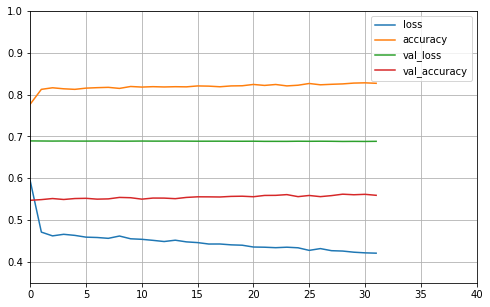

In [127]:
#学習曲線のプロット
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0.35,1)
plt.gca().set_xlim(0,40)
plt.show()

In [119]:
model.evaluate(X_nn, y_nn, verbose=1)

732/732 [==============================] - 1s 1ms/step - loss: nan - accuracy: 0.7201


[nan, 0.7201417684555054]

In [ ]:
model.predict()

In [ ]:
ばちい　増やす　さげる
えぽっく　増やす
欠損値　埋める
中関そう　ふやす
dropaut 追加
aleaystopping 追加
race_id level=0 を削除　もしくわ　カテゴリ変数に直す
logloss 使ってみる